<a href="https://colab.research.google.com/github/SagnikChunder/Smart-Healthcare-Appointment-No-Show-Prediction-and-Resource-Optimization-System/blob/main/Smart_Healthcare_Appointment_No_Show_Prediction_and_Resource_Optimization_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving KaggleV2-May-2016.csv to KaggleV2-May-2016.csv


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("KaggleV2-May-2016.csv")

# View shape and sample rows
print("Shape:", df.shape)
print(df.head())

# Basic info
print(df.info())

# Check missing values
print(df.isnull().sum())

Shape: (110527, 14)
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0       

Cleaning and Preparing Data

In [4]:
# Convert to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Create time gap feature
df['WaitingDays'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Convert No-show to binary
df['No-show'] = df['No-show'].map({'Yes': 1, 'No': 0})

# Check class balance
print(df['No-show'].value_counts(normalize=True))

No-show
0    0.798067
1    0.201933
Name: proportion, dtype: float64


Visualizing Patterns

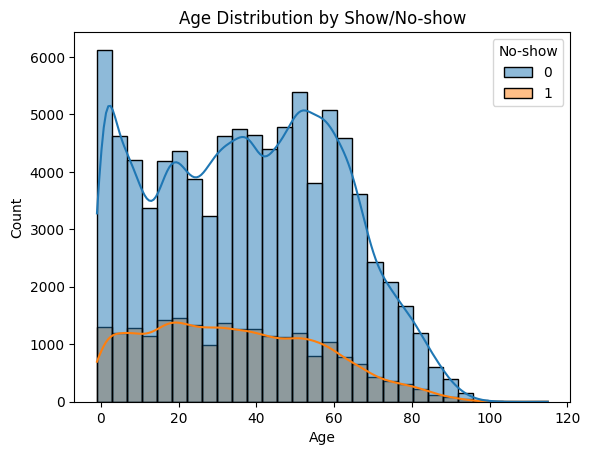

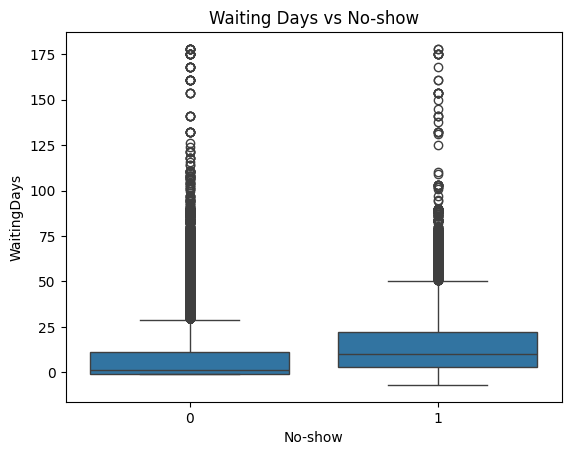

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize age vs. no-show
sns.histplot(data=df, x='Age', hue='No-show', bins=30, kde=True)
plt.title('Age Distribution by Show/No-show')
plt.show()

# Waiting days impact
sns.boxplot(x='No-show', y='WaitingDays', data=df)
plt.title('Waiting Days vs No-show')
plt.show()

Feature Engineering & Selection

In [6]:
# Dropping ID columns that don't help in prediction
df = df.drop(columns=['PatientId', 'AppointmentID'])

# Optional: Remove records with negative ages or waiting days
df = df[df['Age'] >= 0]
df = df[df['WaitingDays'] >= 0]

In [7]:
# Day of the week (0=Monday, ..., 6=Sunday)
df['AppointmentWeekDay'] = df['AppointmentDay'].dt.dayofweek

# Scheduled hour (may help if patient scheduled late at night)
df['ScheduledHour'] = df['ScheduledDay'].dt.hour

In [8]:
# Feature columns (you can tune this list based on model performance)
features = ['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes',
            'Alcoholism', 'Handcap', 'SMS_received', 'WaitingDays',
            'AppointmentWeekDay', 'ScheduledHour']

# Encode categorical variables
df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

# Final X and y
X = df[features]
y = df['No-show']

Train ML Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10275    13]
 [ 4093    11]]
              precision    recall  f1-score   support

           0       0.72      1.00      0.83     10288
           1       0.46      0.00      0.01      4104

    accuracy                           0.71     14392
   macro avg       0.59      0.50      0.42     14392
weighted avg       0.64      0.71      0.60     14392



In [10]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, rf_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost:")
print(classification_report(y_test, xgb_pred))
print("ROC AUC Score:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

Random Forest:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79     10288
           1       0.37      0.20      0.26      4104

    accuracy                           0.67     14392
   macro avg       0.55      0.53      0.53     14392
weighted avg       0.63      0.67      0.64     14392

ROC AUC Score: 0.5763116186575173


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:27:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83     10288
           1       0.45      0.06      0.10      4104

    accuracy                           0.71     14392
   macro avg       0.58      0.51      0.47     14392
weighted avg       0.64      0.71      0.62     14392

ROC AUC Score: 0.6009579329728763


Handling Class Imbalance

Usage of SMOTE (Synthetic Minority Oversampling)

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Train on balanced data
xgb_model_sm = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model_sm.fit(X_train_sm, y_train_sm)
sm_pred = xgb_model_sm.predict(X_test)

print("XGBoost with SMOTE:")
print(classification_report(y_test, sm_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:30:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost with SMOTE:
              precision    recall  f1-score   support

           0       0.75      0.61      0.67     10288
           1       0.33      0.48      0.39      4104

    accuracy                           0.57     14392
   macro avg       0.54      0.55      0.53     14392
weighted avg       0.63      0.57      0.59     14392



Explaining Model Predictions with SHAP

In [12]:
pip install shap

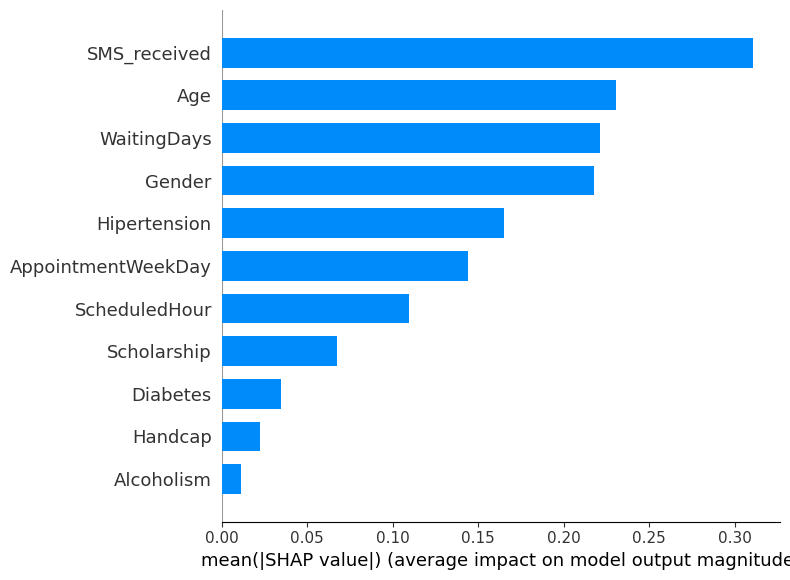

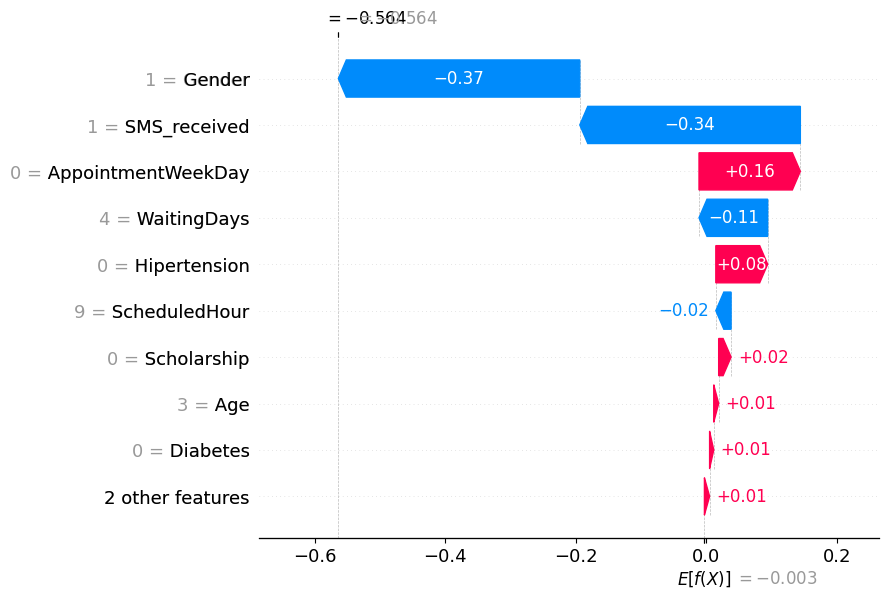

In [13]:
import shap

# Create SHAP explainer
explainer = shap.Explainer(xgb_model_sm)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# individual prediction explanation
shap.plots.waterfall(shap_values[0])

Resource Optimization Based on No-Show Predictions

In [14]:
no_show_probs = xgb_model_sm.predict_proba(X_test)[:, 1]  # Probability patient will not show

In [15]:
high_risk_threshold = 0.7
high_risk_appointments = X_test[no_show_probs > high_risk_threshold]
print("Number of overbookable slots:", len(high_risk_appointments))

Number of overbookable slots: 970


Simulate Cost Based Optimization by Threshold Optimization

In [25]:
import numpy as np

# Simulated predicted probabilities and true labels (replace with your actual data)
np.random.seed(42)
simulated_probs = np.random.beta(2, 5, size=1000)  # Probabilities skewed toward 0
simulated_actuals = np.random.binomial(1, simulated_probs)

# Define cost simulation function
def simulate_costs(probabilities, actuals, threshold):
    cost = 0
    for p, y in zip(probabilities, actuals):
        if p > threshold:
            # Overbooked
            if y == 0:  # Patient shows up => overbook clash
                cost -= 300
            else:       # Patient no-shows => efficient overbook
                cost += 0
        else:
            if y == 1:  # Missed appointment
                cost += 500
    return cost

# Try a range of thresholds
thresholds = np.arange(0.5, 0.95, 0.05)
costs = [simulate_costs(simulated_probs, simulated_actuals, t) for t in thresholds]

# Output results
for t, c in zip(thresholds, costs):
    print(f"Threshold {t:.2f} -> Simulated Cost: ₹{c}")

Threshold 0.50 -> Simulated Cost: ₹99500
Threshold 0.55 -> Simulated Cost: ₹119100
Threshold 0.60 -> Simulated Cost: ₹131500
Threshold 0.65 -> Simulated Cost: ₹140100
Threshold 0.70 -> Simulated Cost: ₹143400
Threshold 0.75 -> Simulated Cost: ₹145200
Threshold 0.80 -> Simulated Cost: ₹145200
Threshold 0.85 -> Simulated Cost: ₹146000
Threshold 0.90 -> Simulated Cost: ₹146000
